In [1]:
from dataclasses import fields
from matplotlib import pyplot as plt
from pandas import DataFrame
import numpy as np
import sea2025
from part1_mp_helpers import clear_offer_stack, clear_offer_stack_fp, plot_offer_stack

Worksheet 1: Marginal pricing
=============================

# Objectives

Revise the notions of economic dispatch and marginal price on the simplest possible network:
* A geometric solution is available
* We'll also consider a linear programming formulation, applicable to general networks

# Examine input data

The format introduced in this section will be used in subsequent activities.

In [2]:
data = sea2025.data.read("data/fc1bus")


Examine the data:

In [3]:
fields(data)

(Field(name='buses',type=<class 'pandas.core.frame.DataFrame'>,default=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,default_factory=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='generators',type=<class 'pandas.core.frame.DataFrame'>,default=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,default_factory=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='lines',type=<class 'pandas.core.frame.DataFrame'>,default=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,default_factory=<dataclasses._MISSING_TYPE object at 0x0000020C9FC1E5D0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='offers',type=<class 'pandas.core.frame.DataFrame'>,default=<datacla

In [4]:
data.buses

,id,load,x,y
0,Bus1,350.0,0.0,0.0


Let's store the load/demand for later use:

In [5]:
assert data.buses.index.size == 1
load = data.buses.at[0, "load"]  # Python indexing starts at 0
load # [MW]

350.0

Note the `fixed_cost` column: It is **not** used in our OPF formulation. We'll return to this later.

In [6]:
data.generators

,id,bus_id,capacity,fixed_cost
0,A,Bus1,200.0,0.0
1,B,Bus1,200.0,6000.0
2,C,Bus1,200.0,8000.0


A trivial network (one bus) has no lines:

In [7]:
assert data.lines.index.size == 0
data.lines  # just column headings - no data rows

,from_bus_id,to_bus_id,capacity,reactance


In [8]:
data.offers

,generator_id,quantity,price,tranche,id
0,A,100.0,65.0,1,A/1
1,A,100.0,110.0,2,A/2
2,B,100.0,40.0,1,B/1
3,B,100.0,90.0,2,B/2
4,C,100.0,25.0,1,C/1
5,C,100.0,35.0,2,C/2


# Geometric solution

> The **Optimal Power Flow** problem is to determine the dispatch that satisfies a specified load/demand at minimum cost.
> As a by-product, the solution procedure furnishes the **marginal price** to use in settling the transactions (between generators and loads).

We'll start with an existing routine to generate the solution (optimal dispatch and marginal price) for the network above.

Take a moment to relate the data above (which tables?) to the geometric solution shown in the plot below.

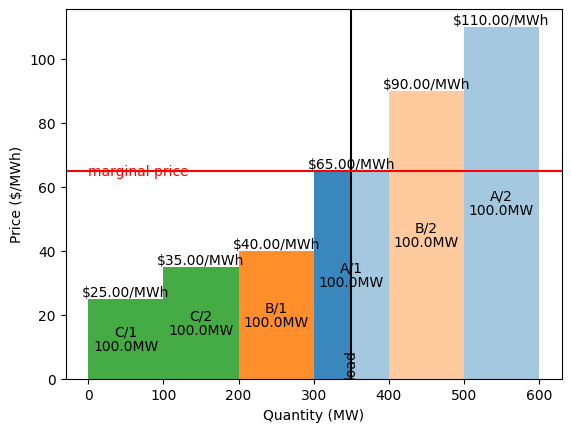

<Figure size 640x480 with 0 Axes>

In [9]:
result = clear_offer_stack(data, load=load)
plot_offer_stack(result.offers, load=load, marginal_price=result.marginal_price)
plt.show(block=False)
plt.savefig("images/offer-stack.png")

# Linear programming solution

The geometric procedure (manual/automated) isn't directly applicable to networks (with multiple buses/lines).

The [linear programming](https://en.wikipedia.org/wiki/Linear_programming) (LP) formulation implemented in the function above is laid out below.

Let's study it and discuss the main components:
* Decision variables `p`
* Power balance constraint
* Capacity constraints

In [10]:
import cvxpy as cp
p = cp.Variable(data.offers.index.size, name="p")
objective = cp.Minimize(cp.sum([data.offers.at[o, "price"] * p[o] for o in data.offers.index]))
balance_constraint = cp.sum([p[o] for o in data.offers.index]) == load
problem = cp.Problem(
    objective,
    [
        balance_constraint,
        p >= 0,
        p <= data.offers["quantity"],
    ],
)
problem.solve(solver=cp.HIGHS)
assert problem.status == cp.OPTIMAL
total_cost = problem.value  # [$/h]
dispatch = p.value  # [MW]
marginal_price = -balance_constraint.dual_value  # [$/MWh] the -sign is convention-dependent

Verify that the results match our graphical solution:

![](images/offer-stack-v1.png)

In [11]:
marginal_price

65.0

In [12]:
DataFrame({"offer": data.offers["id"].values, "dispatch": dispatch})

,offer,dispatch
0,A/1,50.0
1,A/2,-0.0
2,B/1,100.0
3,B/2,-0.0
4,C/1,100.0
5,C/2,100.0


In [13]:
assert np.isclose(total_cost, sum(data.offers["price"].values * dispatch))
total_cost

13250.0

We'll build on this LP solution when we tackle general networks (multiple buses and lines) and the Unit Commitment problem for longer planning horizons.

# _Marginal Costs are not Fixed!_

Recall that the `fixed_cost` column of the `generators` table was **not** used in the calculations above.

_What would happen if we did account for fixed costs in the OPF problem?_

In [14]:
def solve_fp(load: float):
    """Total and cost and increment (with respect to 1MW load increment) for dispatch problem with fixed costs."""
    global data
    result = clear_offer_stack_fp(data, load=load)
    perturbed = clear_offer_stack_fp(data, load=load + 1.0)
    price_delta = perturbed.total_cost - result.total_cost
    return result.total_cost, price_delta

In [15]:
loads = np.linspace(0, data.generators["capacity"].sum() - 1.0, 100)
costs = [solve_fp(load) for load in loads]
total_costs, marginal_costs = zip(*costs)

Skip the plotting commands below and discuss the output with your neighbour:
* How to cost increments relate to marginal costs and to the total cost?
* Can we explain the cost increments in light of the problem data (`generators` and `offers`)?

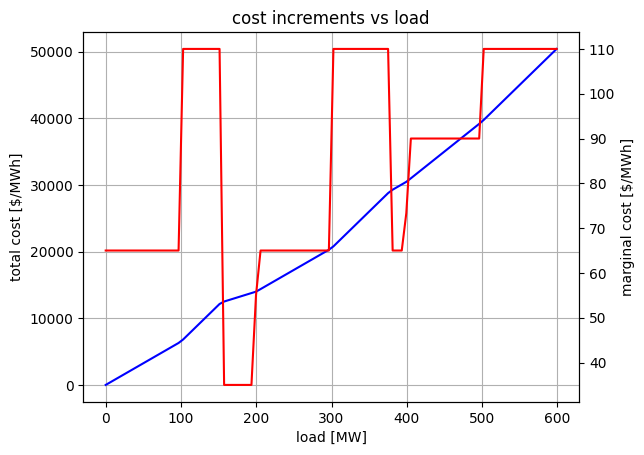

<Figure size 640x480 with 0 Axes>

In [16]:
fig, ax_total = plt.subplots()
ax_marginal = ax_total.twinx()
ax_marginal.plot(loads, marginal_costs, label="marginal cost [$/MWh]", color="red")
ax_marginal.set_ylabel("marginal cost [$/MWh]")
ax_total.plot(loads, total_costs, label="cost [$/MWh]", color="blue")
ax_total.set_xlabel("load [MW]")
ax_total.set_ylabel("total cost [$/MWh]")
ax_total.set_title("cost increments vs load")
ax_total.grid(True)
plt.show(block=False)
plt.savefig("images/non-monotonic-prices.png")